<ipython-input-1-bb14c12c2c99>:56: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  housing.rooms_per_houshold=housing.total_rooms/housing.households


median_house_value          1.000000
median_income               0.687151
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

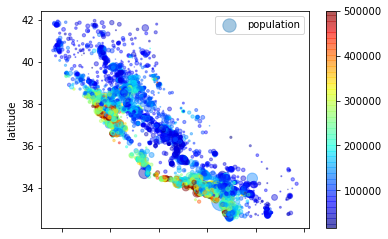

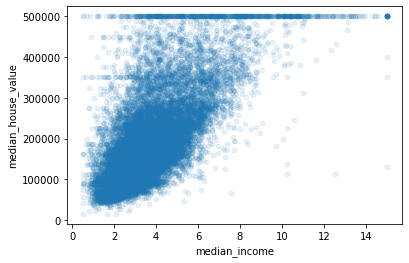

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

url="https://raw.githubusercontent.com/justkacz/csvfiles/main/housing.csv"
h= pd.read_csv(url)
# h.info()
# h.describe()
# h.ocean_proximity.value_counts()
# h.hist(bins=50,figsize=(20,15))
train_set, test_set = train_test_split(h, test_size=0.2, random_state=42)
# train_set.value_counts()

# train_set.hist(column='median_income', bins=5)
h['incom_cat']=np.ceil(h.median_income/1.5)
h.incom_cat.where(h.incom_cat<5, 5.0, inplace=True)
h[['incom_cat', 'median_income']]
# h.incom_cat.hist()

# StratifiedShuffleSplit - the population is divided into homogeneous subgroups called strata,
# and the right number of instances is sampled from each stratum to guarantee that the
# test set is representative of the overall population, 
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(h, h["incom_cat"]):
    strat_train_set = h.loc[train_index]
    strat_test_set = h.loc[test_index]
    
h["incom_cat"].value_counts() / len(h)

for set in (strat_train_set, strat_test_set):
    set.drop(["incom_cat"], axis=1, inplace=True)
    
housing = strat_train_set.copy()
# parametr alpha - kolorem zaznaczone sa punkty o najwyzszej gestosci, s-wielkosc okregu, c-kolor okregu
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, s=housing.population/100, label='population', c=housing.median_house_value, cmap=plt.get_cmap('jet'), colorbar=True)
plt.legend()

# obl korelacji kazdego atrybutu(feature) z innymi - standard correlation coefficient - only LINEAR = Pearson's r - values -1 to 1, close to 0 mean that there is no linear correlation:
# 1) sposob:
corr_matrix=housing.corr()
corr_matrix

# 2) sposob - obl korelacje tylko :
from pandas.plotting import scatter_matrix
# wybor kolumn o najwyzszej korelacji wg wyniku z pierwszego sposobu
kolumny=["median_house_value", "median_income", "total_rooms",
"housing_median_age"]
# scatter_matrix(housing[kolumny], figsize=(12,8))

# najbardziej widoczna zaleznosc z scatter_matrix jest miedzy median house value a median income - proste poziome linie okolo 500, 450, 350 i 280 - powinny zostac usuniete:
housing.plot(kind='scatter', y='median_house_value', x='median_income', alpha=0.1)

housing.rooms_per_houshold=housing.total_rooms/housing.households
# housing.rooms_per_houshold.sort_values(ascending=False)
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]
housing.corr()["median_house_value"].sort_values(ascending=False)


In [3]:
# DATA CLEANING:
housing=strat_train_set.drop("median_house_value", axis=1)
housing_label=strat_train_set["median_house_value"].copy()

# • Get rid of the corresponding districts.
# housing.dropna(subset=['total_bedrooms'])

# • Get rid of the whole attribute -drop tworzy kopie bez kolumny usuwanej
# housing.drop('total_bedrooms', axis=1)

# • Set the values to some value (zero, the mean, the median, etc.)-wypelnione mediana musza byc takze missing values z test_set
# median=housing.total_bedrooms.median()
# housing.total_bedrooms.fillna(median)

# Scikit-Learn provides a handy class to take care of missing values: Imputer.
from sklearn.impute import SimpleImputer
imputer=SimpleImputer(strategy='median')

# mediana-tylko dla kolumn numerycznych-koniecznosc wyeliminowania kolumn z wartosciami tekstowymi
housing_num=housing.drop('ocean_proximity', axis=1)
# policzy mediane dla kazdj kolumny
imputer.fit(housing_num) 
# imputer.statistics_
# wypelni policzona mediane w miejsce brakujacych wartosci 
X=imputer.transform(housing_num)
# zamiana X na Dataframe:
housing_num=pd.DataFrame(X, columns=housing_num.columns)

# 1) Zmiana na wartosci numeryczne kolumny tekstowej-algorithms will assume that two nearby values are more similar than two distant values.
# from sklearn.preprocessing import LabelEncoder
# encoder=LabelEncoder()
# housing_cat_encoded=encoder.fit_transform(housing['ocean_proximity'])
# wyswietla wartosci tekstowe przypisane do kolejnych liczb zaczynajac od 0
# encoder.classes_

# 2) ONE HOT ENCODER - lepsze rozwiazanie, przypisuje 0 lub 1, eliminacja algorithms will assume that two nearby values are more similar than two distant values;
# nie mozna uzyc 1D array -> array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample; series.values->przekonwertuje de pd.Array
from sklearn.preprocessing import OneHotEncoder
encoder=OneHotEncoder()
housingoh=encoder.fit_transform(housing['ocean_proximity'].values.reshape(-1, 1)) 

#  wynikiem onehotencoder jest sparse matrix - w pamieci przechowywane sa tylko wartosci 1 bez 0; zeby wyswietlic kolumny nalezy uzyc metody toarray()
housingoh.toarray()

# 3) pkty 1 i 2 sa polaczone w klasie LabelBinarizer-od razu wyswietla array, jesli chcemy sparse matrix - dodac parametr sparse_output=True:
from sklearn.preprocessing import LabelBinarizer
encoder=LabelBinarizer(sparse_output=True)
housinglb=encoder.fit_transform(housing['ocean_proximity'])


In [100]:
# FEATURE SCALING - scaling the target values is generally not required.
# 1) MinMax scaling = normalization, normally 0-1, class MinMaxScaler has hyperparameter feature_range that allows to change the range
#  xscaled = (x - najmniejsza wart w zbiorze)/(max zbioru - min zbioru), it is going to be biased if data contains outliers

# 2) Standardization - xstandardized = (x-srednia zbioru)/odchylenie standardowe
# odch.stand = pierwiastek z sumy: (x-srednia zbioru)^2
from sklearn.preprocessing import StandardScaler
encoder=StandardScaler()
housingscal=encoder.fit_transform(housing_num)

# PIPELINE - When you call the pipeline’s fit() method, it calls fit_transform() sequentially on all transformers, 
# passing the output of each call as the parameter to the next call, until it reaches the final estimator, for which it just calls the fit() method.
# FeatureUnion - pozwala na polaczenie pipeline dotyczacych wartosci numerycznych i tekstowych
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler

# num_attribs = list(housing_num)
# cat_attribs = ["ocean_proximity"]

# # selector - cusom transformer to convert pd.Dataframe into numpy.array
# from sklearn.base import BaseEstimator, TransformerMixin
# class DataFrameSelector(BaseEstimator, TransformerMixin):
#     def __init__(self, attribute_names):
#         self.attribute_names = attribute_names
#     def fit(self, X, y=None):
#         return self
#     def transform(self, X):
#         return X[self.attribute_names].values


# # CombinedAttributesAdder() - custom transformer, doesn't work, old version
    
# num_pipeline = Pipeline([
# ('selector', DataFrameSelector(num_attribs)),
# ('imputer', SimpleImputer(strategy="median")),
# ('attribs_adder', CombinedAttributesAdder()),
# ('std_scaler', StandardScaler()),
# ])
# cat_pipeline = Pipeline([
# ('selector', DataFrameSelector(cat_attribs)),
# ('label_binarizer', LabelBinarizer()),
# ])
# full_pipeline = FeatureUnion(transformer_list=[
# ("num_pipeline", num_pipeline),
# ("cat_pipeline", cat_pipeline),
# ])

housing_prep = np.concatenate((housingscal, housinglb.toarray()), axis=1)
# housing_prep = full_pipeline.fit_transform(housing)
housing_prep

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

In [113]:
# SELECT AND TRAIN MODEL
from sklearn.linear_model import LinearRegression
modelreg=LinearRegression()
modelreg.fit(housing_prep, housing_label)

from sklearn.metrics import mean_squared_error
hpredictions=modelreg.predict(housing_prep)
lin_mse = mean_squared_error(housing_label, hpredictions)
lin_mse= np.sqrt(lin_mse)
lin_mse
# clearly not a great score: most districts’median_housing_values range between $120,000 and $265,000, so a typical prediction
# error of $68,628 is not very satisfying, model underfitting the training data (features might not provide enough inf or model is not powerful enough)


69050.56219504567

In [115]:
# LOOKING FOR A BETTER MODEL:
# Decision Tree
from sklearn.tree import DecisionTreeRegressor
model=DecisionTreeRegressor()
model.fit(housing_prep, housing_label)
predictions=model.predict(housing_prep)
tree_mse = mean_squared_error(housing_label, predictions)
tree_mse=np.sqrt(tree_mse)
tree_mse
#  0 - data overfitting

# k-folds cross validation - it randomly splits the training set into 10 distinct subsets called folds, then it trains and evaluates the Decision Tree model 10 times,
# picking a different fold for evaluation every time and training on the other 9 folds; used instead of extracting validation data for comparison
from sklearn.model_selection import cross_val_score
#  1) Decision Tree:
scoresdt=cross_val_score(model, housing_prep, housing_label, scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scoresdt)
rmse_scores.mean()

#  2) Lin Reg:
scores=cross_val_score(modelreg, housing_prep, housing_label, scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)
rmse_scores.mean()

69204.32275494763

In [127]:
# FINE TUNE MODEL - looking for the best combination of the hyperparameters 
# 1) GRID SEARCH - class GridSearchCV - cross validation
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# 'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8] - trzy w pierwszym słowniku x cztery w drugiej = 12 kombinacji
# 'n_estimators': [3, 10], 'max_features': [2, 3, 4] - dwa w pierwszym słowniku i trzy w drugim = 6 kombinacji
# cv - how many times each model will be trained
#  5 times each model will be trained with 12 +  6 combinations =18 so finally there will be 90 rounds of training
param_grid = [
{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
{'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

model = RandomForestRegressor()
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(housing_prep, housing_label)
# grid_search.best_params_
# grid_search.best_estimator_

# all results:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)
    
# 2) RandomizedSearchCV - evaluates a given number of random combinations by selecting a random value for each hyperparameter at every iteration
# 3) Ensemble model - Another way to fine-tune your system is to try to combine the models that perform best. The group (or “ensemble”) will 
# often perform better than the best individual model


63606.00235923707 {'max_features': 2, 'n_estimators': 3}
55180.9029553751 {'max_features': 2, 'n_estimators': 10}
52824.98061560275 {'max_features': 2, 'n_estimators': 30}
58978.87246138208 {'max_features': 4, 'n_estimators': 3}
53623.539114008665 {'max_features': 4, 'n_estimators': 10}
50619.51617868111 {'max_features': 4, 'n_estimators': 30}
58652.863636436035 {'max_features': 6, 'n_estimators': 3}
52272.48816524208 {'max_features': 6, 'n_estimators': 10}
50391.503836202326 {'max_features': 6, 'n_estimators': 30}
58380.83053847216 {'max_features': 8, 'n_estimators': 3}
51941.90835639027 {'max_features': 8, 'n_estimators': 10}
50170.98075769347 {'max_features': 8, 'n_estimators': 30}
62131.96751464285 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
53910.97763009377 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59604.39595147706 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52933.32830612761 {'bootstrap': False, 'max_features': 3, 'n_estimators': 

In [133]:
# CLASSIFICATION
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')
X, y = mnist["data"], mnist["target"]
# X = features, liczba wierszy to ilosc zdjec, kazdy piksel przyjmujacy wartosci 0 (bialy) do 255 (czarny) ukazany jest w osobnej kolumnie, jesli zdjecie sklada sie z 28x28 pikseli uzyskamy 784 kolumny
X.shape
y.shape

import matplotlib.pyplot as plt
digit = X[36000]
digit_arr=digit.reshape(28, 28)
plt.imshow(digit_arr, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.show()


KeyError: 36000